In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import re

<h1>1. Dataset Exploration & Understanding</h1>

In [31]:
# number of partipants
'''
In the description there are
48 participants
'''

# Days recorded per participant
min_date = None
max_date = None

for file in os.listdir("./dataset/calendar/"):
    df = pd.read_csv(f"./dataset/calendar/{file}")
    if min_date == None and max_date == None:
        min_date = df['DATE'].min()
        max_date = df['DATE'].max()
    else:
        if df['DATE'].min() < min_date:
            min_date = df['DATE'].min()

        if df['DATE'].max() > max_date:
            max_date = df['DATE'].max()

print(f"Earliest Date: {min_date}")
print(f"Latest Date: {max_date}")
print()


# Demographic diversity (age, gender)

'''
48 undergrads and grad students
doesn't specify gender
'''

# Total datapoints and labels
 
total_datapoints = 0
total_labels = 0
for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")
    total_datapoints += df.shape[0]
    total_labels += len(df['provider'].unique())

print(f"Total Datapoints: {total_datapoints}")
print(f"Total Labels: {total_labels}")
print()

# Datapoints per label

per_label = pd.Series(dtype="float64")  

for file in os.listdir("./dataset/sensing/gps/"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}")

    counts = (
        df.groupby("provider", dropna=False)
          .agg(rows=("provider", 'size'))
    )

    per_label = per_label.add(counts['rows'], fill_value=0)

per_label = per_label.astype(int).sort_values(ascending=False)
print(per_label)

# Input streams (accelerometer, gyro, annotations, etc.) 

'''
time
provider
network_type
accuracy
latitude
longitude
altitude
bearing
speed
travelstate
'''

Earliest Date: 03/27/2013
Latest Date: 6/8/2013

Total Datapoints: 202877
Total Labels: 117

wifi    187613
NaN      10744
cell      4520
dtype: int64


'\ntime\nprovider\nnetwork_type\naccuracy\nlatitude\nlongitude\naltitude\nbearing\nspeed\ntravelstate\n'

<h1>2. Annotation & Signal Exploration</h1>

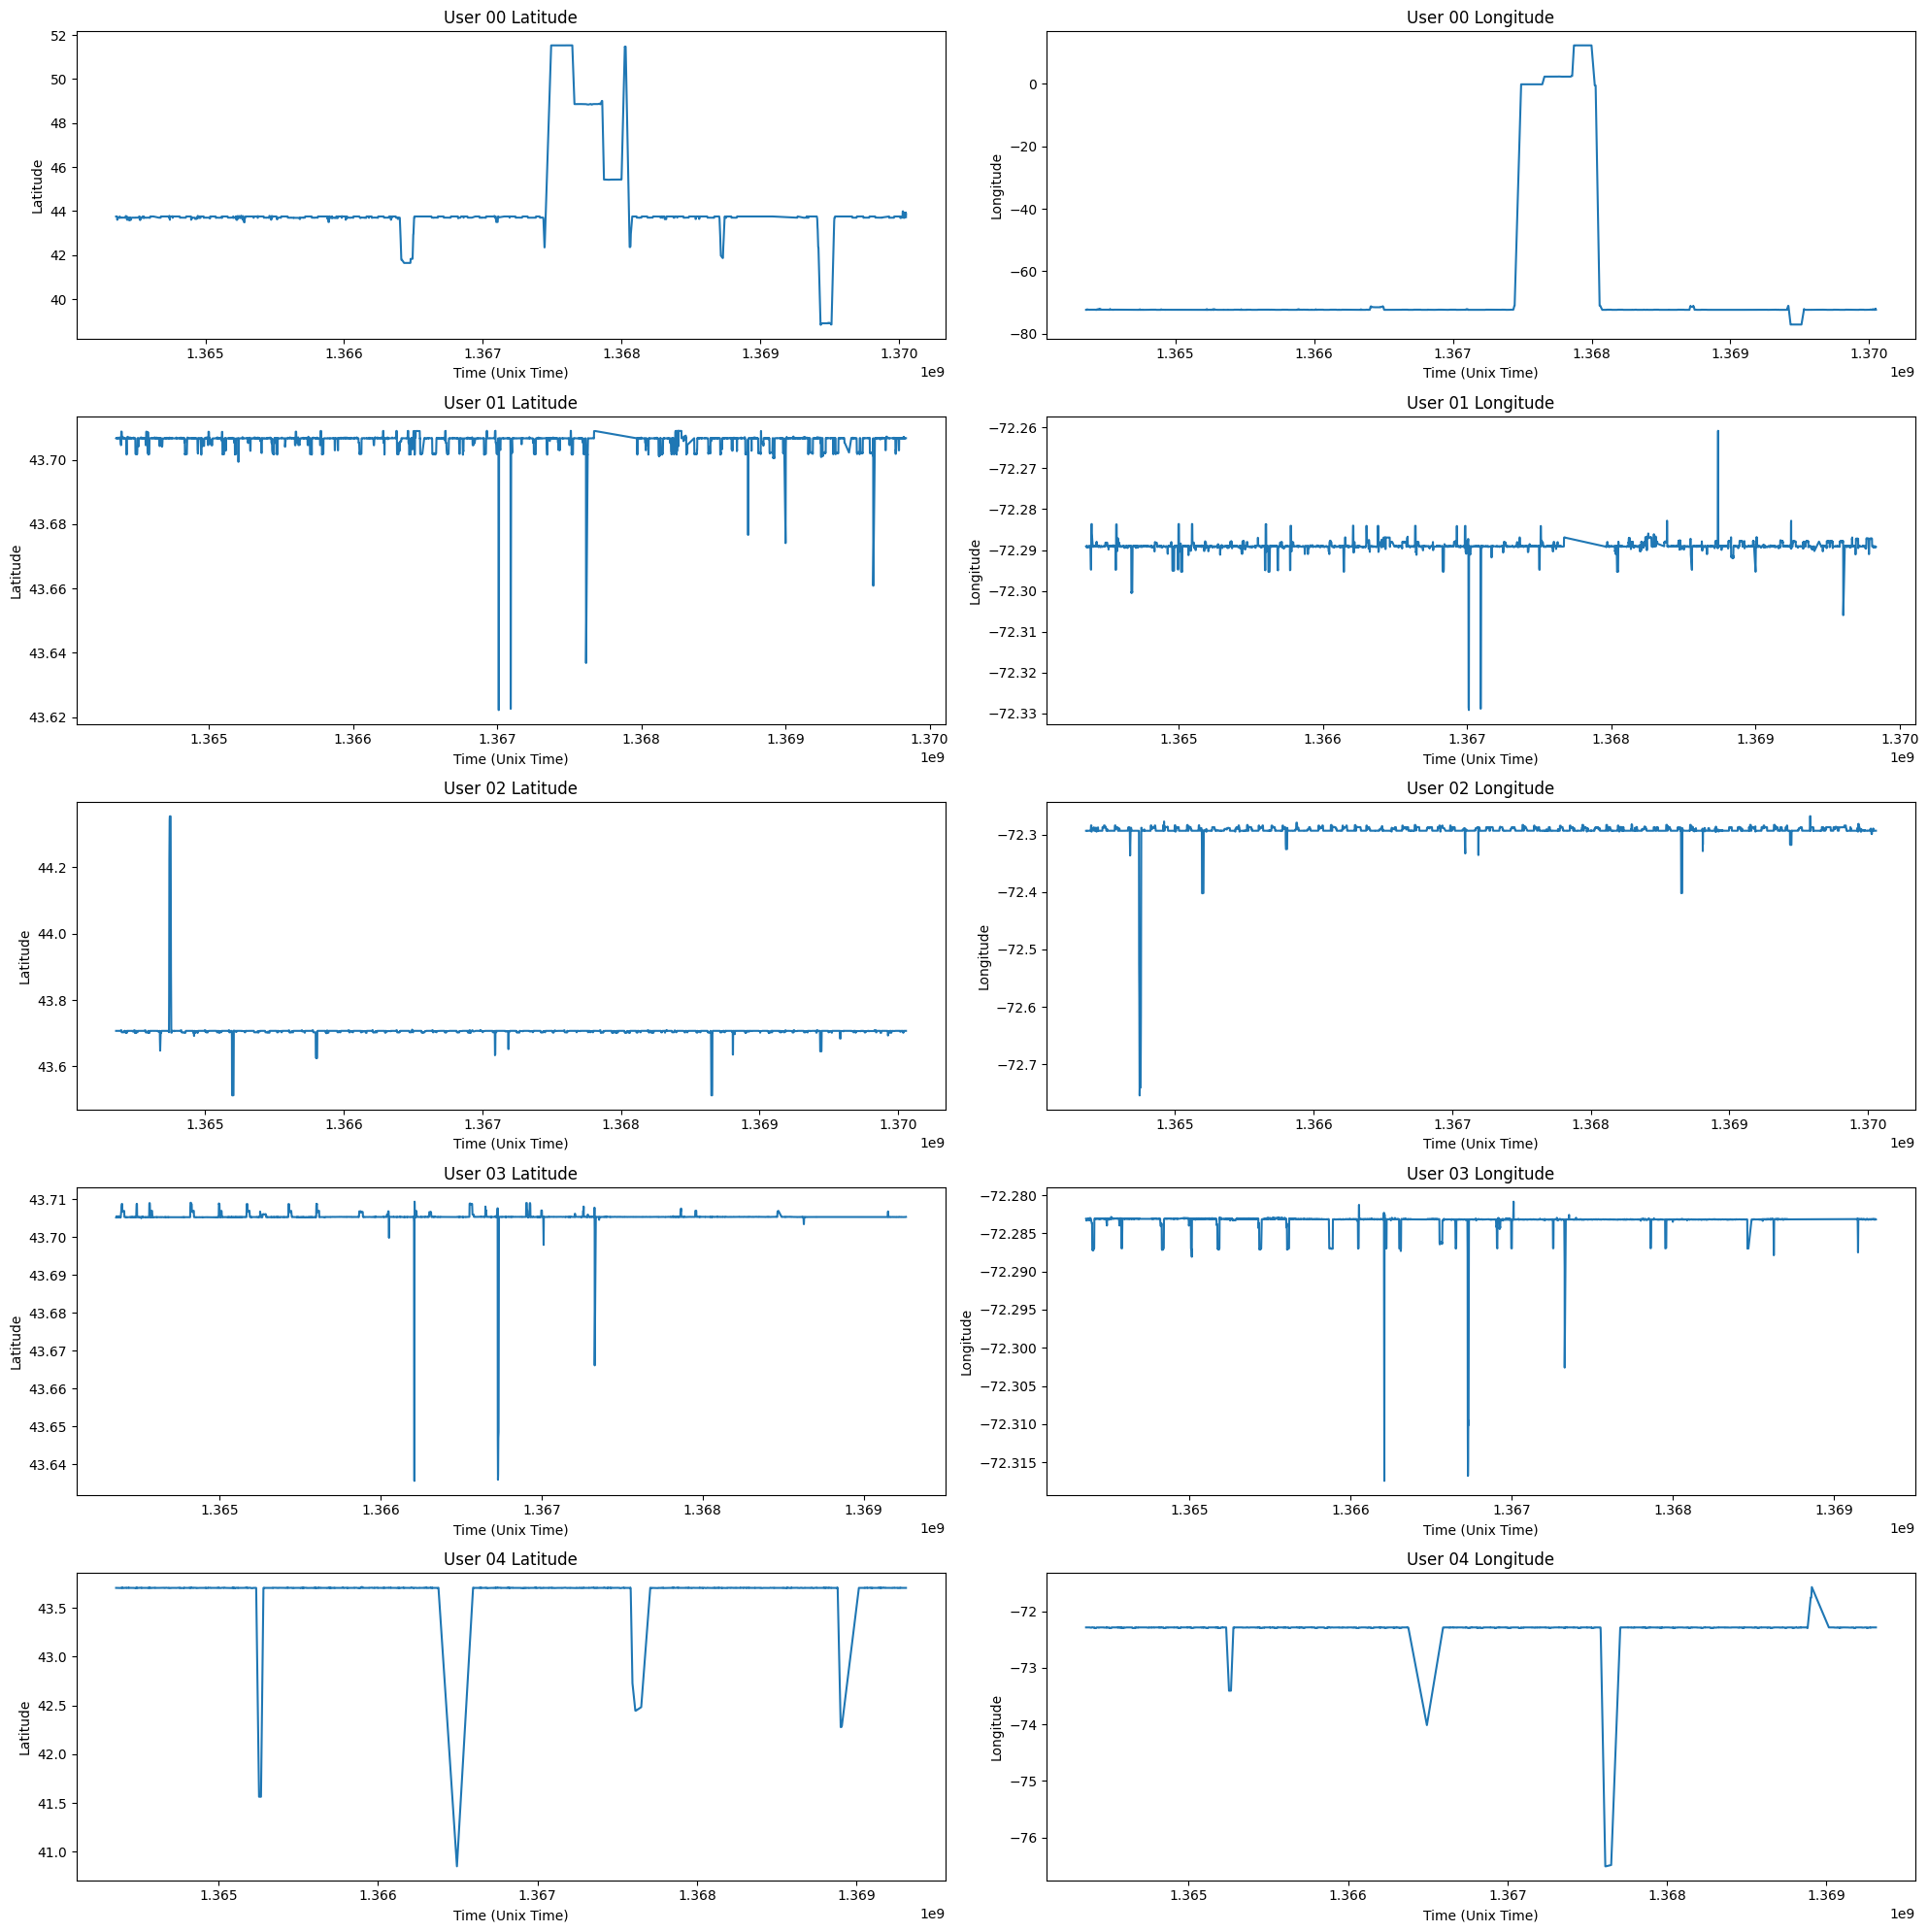

In [32]:
# General latitude and longitude plots
fig, axes = plt.subplots(5, 2, figsize=(20,20))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    axes[i][0].plot(df['time'], df['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(df['time'], df['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Longitude')  
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')  

    if i == 4:  # limit to first 5 users
        break

plt.tight_layout()
plt.show()

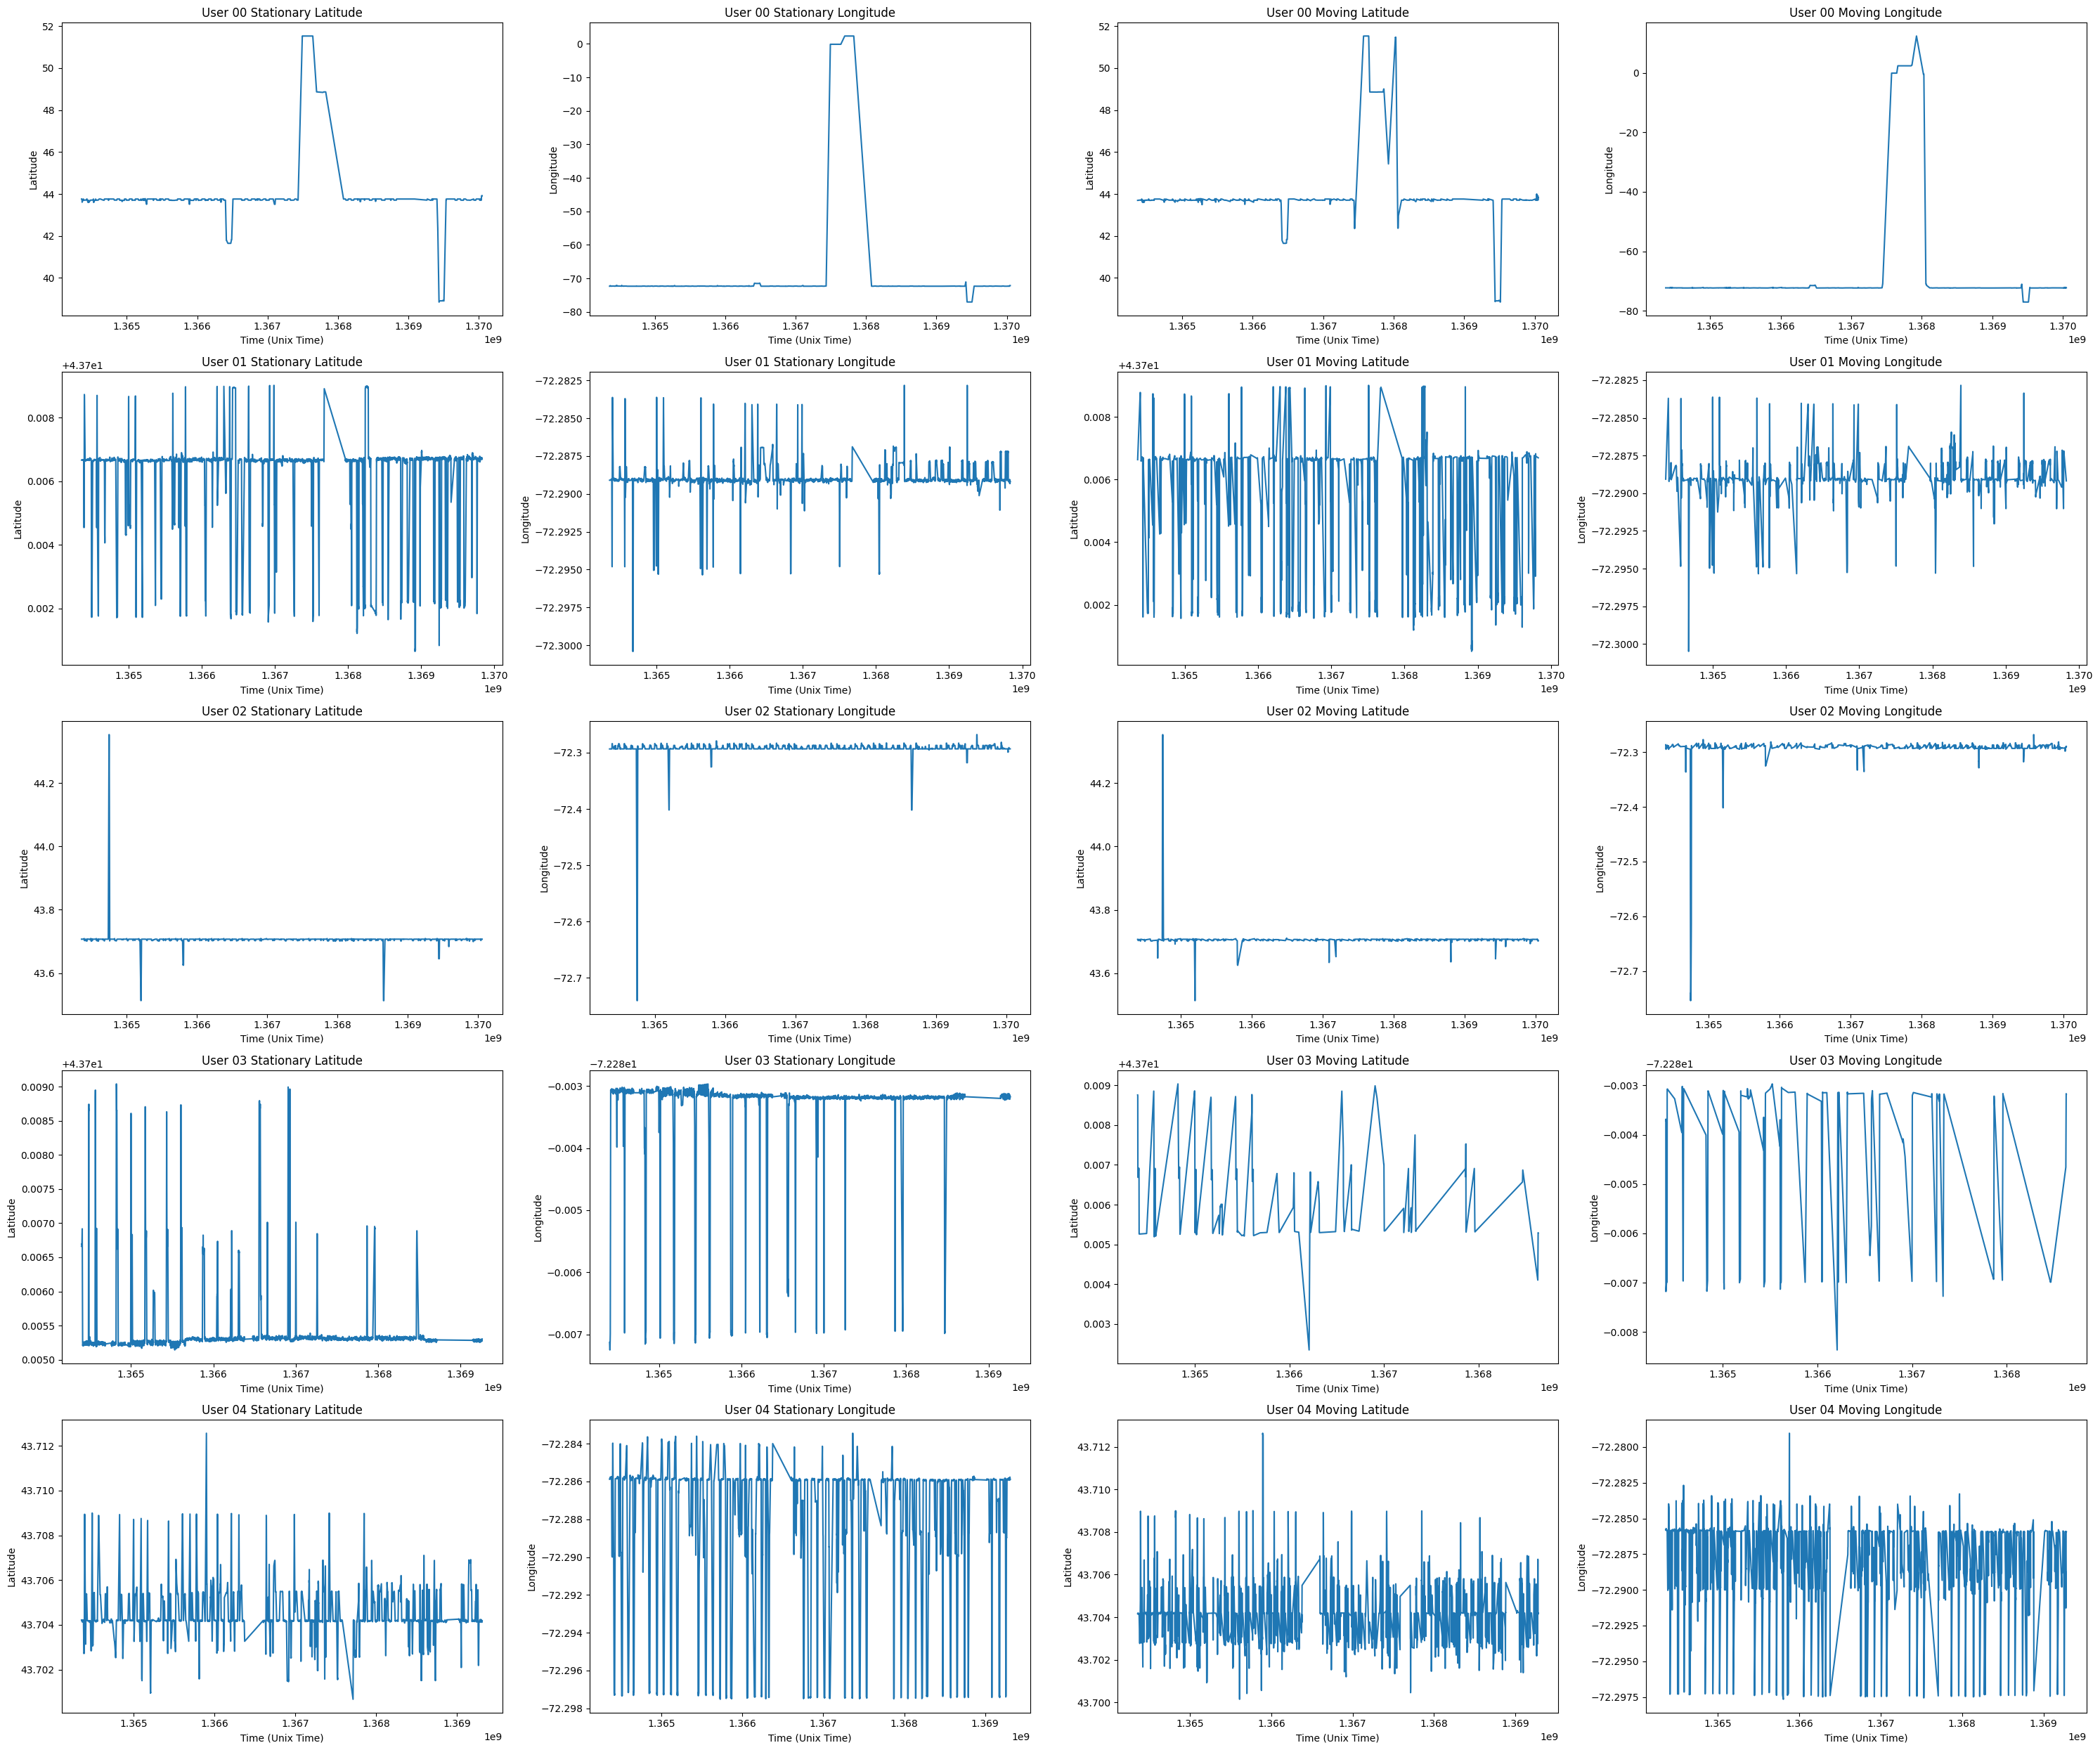

In [33]:
# Longitude and latitude plots based on travel state

fig, axes = plt.subplots(5, 4, figsize=(30,25))

for i,file in enumerate(os.listdir("./dataset/sensing/gps/")):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", index_col=False)
    user = re.findall(r'\d+', file)[0]
    stationary = df[df['travelstate'] == 'stationary']
    axes[i][0].plot(stationary['time'], stationary['latitude'])
    axes[i][0].set_title('User ' + str(user) + ' Stationary Latitude')
    axes[i][0].set_xlabel('Time (Unix Time)')
    axes[i][0].set_ylabel('Latitude')
    axes[i][1].plot(stationary['time'], stationary['longitude'])
    axes[i][1].set_title('User ' + str(user) + ' Stationary Longitude') 
    axes[i][1].set_xlabel('Time (Unix Time)')
    axes[i][1].set_ylabel('Longitude')

    moving = df[df['travelstate'] == 'moving']
    axes[i][2].plot(moving['time'], moving['latitude'])
    axes[i][2].set_title('User ' + str(user) + ' Moving Latitude')
    axes[i][2].set_xlabel('Time (Unix Time)')
    axes[i][2].set_ylabel('Latitude')
    axes[i][3].plot(moving['time'], moving['longitude'])
    axes[i][3].set_title('User ' + str(user) + ' Moving Longitude') 
    axes[i][3].set_xlabel('Time (Unix Time)')
    axes[i][3].set_ylabel('Longitude')
      

    if i == 4:  # preventing the graph from being too long since 2 travel states * 2 coords (lat/long) * 49 user graphs
        break 

plt.tight_layout()
plt.show()

<h1>3. Signal Preprocessing</h1>

In [34]:
# Resampling to uniform frequency

resampled_df = pd.DataFrame()

for path in os.listdir("./dataset/sensing/gps"):
    df = pd.read_csv(f"./dataset/sensing/gps/{file}", sep=",", index_col=False, skipinitialspace=True)

    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    df["timestamp"] = pd.to_datetime(df["time"], unit="s", utc=True, errors="coerce")

    df = (df.dropna(subset=["timestamp"])
            .sort_values("timestamp")
            .drop_duplicates("timestamp"))

    # Does a 1 min resample
    # Picks the first record with each min
    g = (df.set_index("timestamp")
           .resample("1min")
           .first()
           .reset_index())

    # Drop minutes that were created by resample but had no data
    g = g.dropna(subset=["time"])

    resampled_df = pd.concat([resampled_df, g], ignore_index=True)

# Makes sure there is no duplicates for each min
# If there is a duplicate then the earliest timestamp is kept
resampled_df = (resampled_df.sort_values("timestamp").drop_duplicates(subset=["timestamp"], keep="first"))

resampled_df

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,2013-03-27 04:06:00+00:00,1.364357e+09,network,wifi,27.000,43.704217,-72.285881,0.0,0.0,0.0,stationary
118273,2013-03-27 04:26:00+00:00,1.364358e+09,network,wifi,33.000,43.704169,-72.285786,0.0,0.0,0.0,moving
125442,2013-03-27 04:46:00+00:00,1.364360e+09,network,wifi,31.500,43.704192,-72.285832,0.0,0.0,0.0,stationary
118275,2013-03-27 05:06:00+00:00,1.364361e+09,network,wifi,25.000,43.704200,-72.285841,0.0,0.0,0.0,stationary
17924,2013-03-27 05:26:00+00:00,1.364362e+09,network,wifi,22.000,43.704196,-72.285842,0.0,0.0,0.0,moving
...,...,...,...,...,...,...,...,...,...,...,...
35835,2013-05-23 10:37:00+00:00,1.369305e+09,network,wifi,26.914,43.704177,-72.285882,0.0,0.0,0.0,stationary
121852,2013-05-23 10:57:00+00:00,1.369307e+09,network,wifi,49.750,43.704159,-72.285766,0.0,0.0,0.0,stationary
89597,2013-05-23 11:17:00+00:00,1.369308e+09,network,wifi,50.056,43.704117,-72.285825,0.0,0.0,0.0,stationary
86014,2013-05-23 11:37:00+00:00,1.369309e+09,network,wifi,24.741,43.704153,-72.285911,0.0,0.0,0.0,stationary


In [35]:
# Apply filtering (noise reduction)

filtered_df = resampled_df

# Noise reduction on the lat and lon values
filtered_df["filtered_latitude"]  = filtered_df["latitude"].rolling(3, center=True, min_periods=1).median()
filtered_df["filtered_longitude"] = filtered_df["longitude"].rolling(3, center=True, min_periods=1).median()

filtered_df.head(10)

,timestamp,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,filtered_latitude,filtered_longitude
0,2013-03-27 04:06:00+00:00,1.364357e+09,network,wifi,27.0,43.704217,-72.285881,0.0,0.0,0.0,stationary,43.704193,-72.285834
118273,2013-03-27 04:26:00+00:00,1.364358e+09,network,wifi,33.0,43.704169,-72.285786,0.0,0.0,0.0,moving,43.704192,-72.285832
125442,2013-03-27 04:46:00+00:00,1.364360e+09,network,wifi,31.5,43.704192,-72.285832,0.0,0.0,0.0,stationary,43.704192,-72.285832
118275,2013-03-27 05:06:00+00:00,1.364361e+09,network,wifi,25.0,43.704200,-72.285841,0.0,0.0,0.0,stationary,43.704196,-72.285841
17924,2013-03-27 05:26:00+00:00,1.364362e+09,network,wifi,22.0,43.704196,-72.285842,0.0,0.0,0.0,moving,43.704196,-72.285841
75269,2013-03-27 05:46:00+00:00,1.364363e+09,network,wifi,31.5,43.704175,-72.285804,0.0,0.0,0.0,moving,43.704175,-72.285804
17926,2013-03-27 06:06:00+00:00,1.364364e+09,network,wifi,27.0,43.704139,-72.285706,0.0,0.0,0.0,moving,43.704139,-72.285763
100359,2013-03-27 06:26:00+00:00,1.364366e+09,network,wifi,28.0,43.704131,-72.285763,0.0,0.0,0.0,stationary,43.704139,-72.285763
89608,2013-03-27 06:46:00+00:00,1.364367e+09,network,wifi,27.0,43.704165,-72.285778,0.0,0.0,0.0,stationary,43.704165,-72.285778
136201,2013-03-27 07:06:00+00:00,1.364368e+09,network,wifi,31.5,43.704175,-72.285807,0.0,0.0,0.0,moving,43.704174,-72.285792


In [36]:
src = filtered_df.copy().sort_values("timestamp")

lat_col = "filtered_latitude"  if "filtered_latitude"  in src.columns else "latitude"
lon_col = "filtered_longitude" if "filtered_longitude" in src.columns else "longitude"

full_idx = pd.date_range(
    src["timestamp"].min().floor("min"),
    src["timestamp"].max().ceil("min"),
    freq="1min", tz="UTC"
)

dfi = (src[["timestamp", lat_col, lon_col]]
         .rename(columns={lat_col: "lat_obs", lon_col: "lon_obs"})
         .set_index("timestamp")
         .reindex(full_idx))

# gap_min = 10
# lat_i = dfi["lat_obs"].interpolate(method="time", limit=gap_min, limit_direction="both")
# lon_i = dfi["lon_obs"].interpolate(method="time", limit=gap_min, limit_direction="both")

# if you want to add back the 10min limit then uncomment the lines above and comment out the two lines below this
lat_i = dfi["lat_obs"].interpolate(method="time", limit_direction="both")
lon_i = dfi["lon_obs"].interpolate(method="time", limit_direction="both")

lat_final = dfi["lat_obs"].where(dfi["lat_obs"].notna(), lat_i)
lon_final = dfi["lon_obs"].where(dfi["lon_obs"].notna(), lon_i)

interploated_df = (pd.DataFrame({
            "timestamp": full_idx,
            "latitude":  lat_final,
            "longitude": lon_final
          })
          .reset_index(drop=True))


interploated_df.head()


,timestamp,latitude,longitude
0,2013-03-27 04:06:00+00:00,43.704193,-72.285834
1,2013-03-27 04:07:00+00:00,43.704193,-72.285834
2,2013-03-27 04:08:00+00:00,43.704193,-72.285833
3,2013-03-27 04:09:00+00:00,43.704193,-72.285833
4,2013-03-27 04:10:00+00:00,43.704193,-72.285833


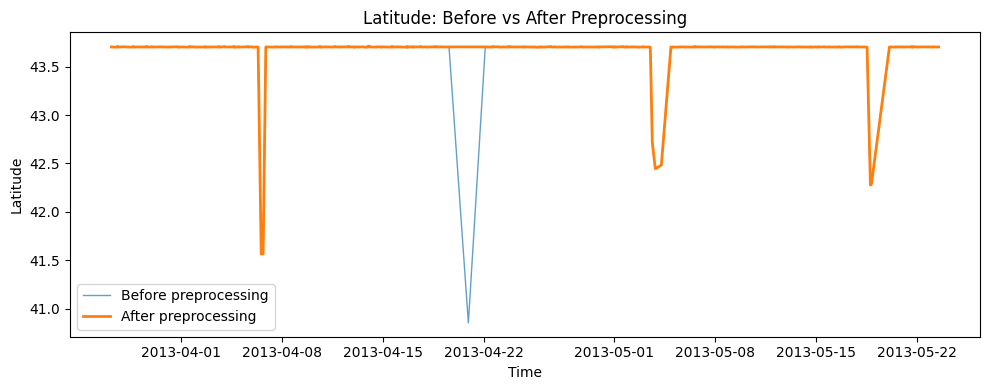

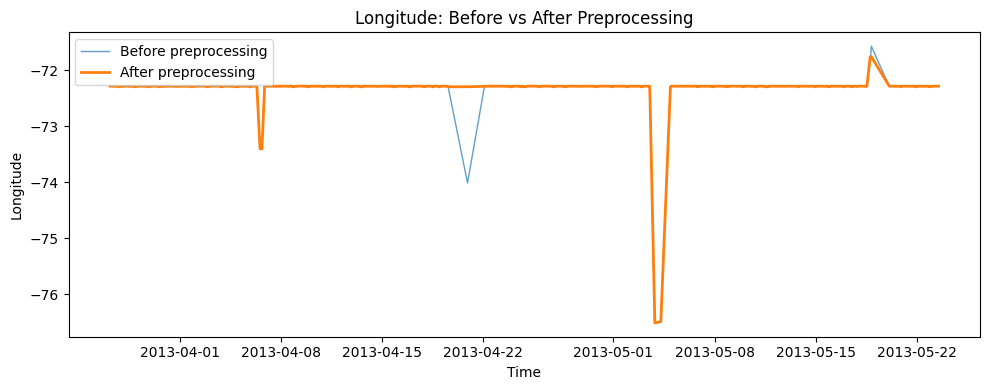

In [37]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,4))
plt.plot(filtered_df["timestamp"], filtered_df["latitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["latitude"], label="After preprocessing", linewidth=2)
plt.title("Latitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Latitude")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(filtered_df["timestamp"], filtered_df["longitude"], label="Before preprocessing", linewidth=1, alpha=0.7)
plt.plot(interploated_df["timestamp"], interploated_df["longitude"], label="After preprocessing", linewidth=2)
plt.title("Longitude: Before vs After Preprocessing")
plt.xlabel("Time")
plt.ylabel("Longitude")
plt.legend()
plt.tight_layout()
plt.show()


<h1>4. Windowing Strategies</h1>

<h1>5. Feature Extraction & Analysis</h1>

<h1>6. Modeling & Evaluation</h1>